# Introduction

Consider a standard RCT, with the following treatment and control groups:

* The treatment group is assigned to the medical plan described [here](https://www.overcomingbias.com/2007/10/buy-health-not.html), where your "health provider" (1) can veto any treatment you want them to pay for, and (2) gets paid each year based on an evaluation of your quality of life.

* The control group is assigned to a standard medical plan, e.g. medicaid.

Assume there are $n / 2$ subjects in each group, so $n$ subjects in total.

The aim here is to determine the sample size $n$ required to gain a >80% probability of observing a statistically significant ($p < 0.05$) effect of this treatment.

I estimate the required sample size below.

First, I describe the basic model of the experiment I will use to make the sample size estimate.
Then, I estimate the "parameters" of this model - in other words, the effect size.
Last, I use the model and the parameters I came up with to estimate the required sample size.

# Assumptions

For now, let's make the following simplifying assumptions:

* Study participants all have the same baseline distribution of mortality over time, ignoring any treatments. In other words, they have the same baseline hazard function $h(t)$ over the study period (where $t = 0$ at the study start).

* The treatment helps / hurts subjects by multiplying their baseline hazard function $h(t)$ by a constant factor $r$.

For outcome data, we use two variables:
$$
D_i =
    \begin{cases}
        1 \quad \text{if subject $i$ dies during the study} \\
        0 \quad \text{otherwise} 
    \end{cases}
$$
and
$T_i$, a continuous variable representing the time at which the subject died.
(If $D_i = 0$, then we set $T_i = k$ where $k$ is the length of the study, i.e. the "censoring" time.)

We need to estimate two key quantities in order to determine the required sample size. These are:

* $p$, the probability that a given subject dies during the study.

* $r$, the hazard ratio between the two groups.

I try to estimate these in the next section.

# Parameter Estimates

## Mortality Probability $p$

According to Wikipedia, the hazard function $h(t)$ of human mortality above the age of 30 is well-described as the sum of an exponentially increasing age-dependent component (i.e. "ageing"), and a constant age-dependent component (i.e. "random accidents").
In other words,
$$
h(t) = ae^{bt} + c
$$
for constants $a$, $b$ and $c$.

This is known as the [Gompertz-Makeham Law of Mortality](https://en.wikipedia.org/wiki/Gompertz%E2%80%93Makeham_law_of_mortality).

If we neglect the constant term $c$, then the probability of mortality for an individual with initial age $v$ over $k$ years is
$$
\begin{split}
p   & = 1 - \exp\left(-\int_0^k h(t) dt\right) \\
    & = 1 - \exp\left(-\frac{a_v}{b}(e^{bk} - 1)\right)
\end{split}
$$
where $a_v = a e^{bv}$ is the individual's initial hazard $h(0)$.

In [1]:
import numpy as np

In [2]:
def compute_mortality_probability(a, b, v, k):
    exp = np.exp
    a_v = a * exp(b * v)
    return 1 - exp(- a_v / b * (exp(b * k) - 1))

This paper provides many estimates of the parameters $a$ and $b$: [Models for estimating empirical Gompertz mortality: With an application to evolution of the Gompertzian slope](https://u.demog.berkeley.edu/~andrew/papers/tai_noymer_authorfinal.pdf).

## Hazard Ratio $r$

Rather than providing a single point estimate of the mortality ratio between the treatment and control groups, I will look at various pieces of relevant evidence, and use this evidence to construct an "informed prior" over the mortality ratio $r$.
I'll show what sample size you expect to need under this prior; but I'll also show how the required sample size varies with the key parameters of my model ($r$ and $p$), in case you disagree with my prior.

Two papers that provide relevant information on the likely mortality ratio are discussed below.

### Evidence from Canceled Doctor Appointments

The first piece of evidence comes from this paper: [Mortality Effects of Healthcare Supply Shocks: Evidence Using Linked Deaths and Electronic Health Records](https://www.nber.org/papers/w30553).

Here's a brief summary:

* The study used the "natural experiment" of the first Covid lockdown (in March 2020) to estimate how mortality changes when individuals are induced to consume less medicine.

* As in a normal RCT, they compare two groups: individuals who had outpatient appointments scheduled for just before and just after the start of the lockdown in March 2020.

* The "treatment" individuals experienced was an increased chance of having their appointment canceled as a result of the lockdown.

* They estimate that individuals in the treatment group had a ~5% higher mortality rate over the 12 months after their appointment (3-7% is their approximate 95% CI).

* Using the cancellation rate of appointments, they estimate that "compliers" - people who would've gone to their appointment if not for the lockdown - had a mortality rate that was around 80% higher over the 12 months after their appointment (50% - 110% is their approximate 95% CI).

* The complier group tended to be older and have more comorbidities, relative to the whole sample. (The authors speculate that doctors were more likely to cancel appointments for patients who they thought were at risk from covid.)

You might hope that they estimate the causal effect (in terms of a relative mortality risk) of an outpatient appointment "randomly" being canceled.
Or more precisely, having one outpatient appointment per year randomly canceled.
Let's call this number $r_0$.

Unfortunately, the relevant estimate they give - the relative mortality rate for compliers - overestimates $r_0$.
This is because in the study, compliers are not randomly selected. They tend to be older and have more comorbidities, relative to the sample overall.
As a result, they are comparing mortality rates between groups that differ in their age and comorbidity profiles, as well as in whether their appointments were "randomly" canceled or not.

Since most deaths in both groups are likely concentrated in older individuals with more comorbidites - so these people are the main contributor to the overall (absolute) mortality rate - I'd expect that the bias is not too severe.
Here I'll assume that the causal effect on relative mortality of having an outpatient appointment randomly canceled is 1/2 of the reported value, i.e. 40%, i.e. $r_0 = 1.4$.

### Evidence from a Health Insurance RCT in India

A second piece of evidence comes from this paper: [Effect of Health Insurance in India: A Randomized Controlled Trial](https://www.nber.org/papers/w29576).

Here's a brief summary of the experiment:

* The study was conducted between 2013-2018 in around 450 villages in the Karnataka region of India.

* The sample consisted of around 11,000 households (52,000 individuals) living above the poverty line (corresponding to annual household income greater than around $4000). Households reported having an annual budget of $6000 per year on average.

* Households in the study were randomly assigned to one of four groups, in which they were offered (1) a health insurance plan, called "RSBY", for free, for 3 years; (2) an option to buy the same plan, (3) an option to buy the plan plus an unconditional cash transfer equal to its cost; (4) nothing.

* The RSBY plan covered care including "inpatient treatments, select outpatient surgeries, and diagnostic tests" but not primary care, delivered at either private or public hospitals. The plan paid out up to $2000 per year per household, with no deductibles.

* Various health outcomes were measured by survey 18 months and 42 months after the study start. Specifically, households were asked whether they had been diagnosed with any conditions and how they felt their health was, and hypertension and obesity status were measured directly by the experimenters.

* The effects observed on health outcome measures were indistinguishable from noise: only 3 of \~600 health outcomes were statistically significant (after multiple-testing adjustments), and the distribution of $p$-values from the estimates was consistent with there being no differences between any groups in any health outcome measures.

This experiment gives an indication of the magnitude of any difference in health outcomes between individuals randomized between different health insurance plans.
In particular, for the plan in question (RSBY insurance vs none), no effect was observed.
Given this, we can use the model described above to estimate a rough upper bound for the hazard ratio between individuals with and without the insurance.

The "household sample size" for the "free insurance" treatment group was around 6500 (4400 in the treatment group, and 2100 in the control, Table A3).
Households contained 5 members on average (Table 1), and the insurance only covered only up to 5 members per household; a conservative (low) estimate of the individual sample size is 18,000.
Around 0.12 deaths per household were reported during the 3.5 years of the study (Table A7); a conservative (low) estimate of individuals' mortality probability is one fifth this value, i.e. 0.024.
Based on these numbers, and the statistical test described in the next section, the hazard ratio $r$ for which you are equally likely to see a significant effect vs not (at level $p = 0.05$) is about $r = 0.92$.

The formula used to compute this upper bound can be derived from the results in the next section, and is shown below.

$$
r = \exp\left(-\sqrt{\frac{(z_{\alpha} + z_{\beta})^2}{np}}\right)
$$

In [3]:
from scipy.stats import norm

In [4]:
def compute_required_hazard_ratio(n, p, level, power):
    return np.exp(-np.sqrt((norm.ppf(level) + norm.ppf(1 - power))**2 / (n * p)))

In [5]:
# Hazard ratio such that you're equally likely to see a mortality effect vs not in the Karnataka study
# (under many assumptions)
print(round(compute_required_hazard_ratio(n=18000, p=0.12/5, level=0.05, power=0.5), 3))

0.924


Slightly less conservative estimates give values in the range 0.92-0.97.

This result is compatible with various beliefs about the effectiveness of RSBY insurance, relative to no insurance, for this group:

* RSBY insurance reduced mortality slightly, but its effect was smaller than \~5% so it could not be distinguished from noise.

* RSBY insurance had no effect (or a slightly negative effect) on mortality.

* RSBY insurance caused a substantial (>10%) reduction in mortality, but measurement error (e.g. inaccurate survey answers) increased the level of noise to the point where it was not detectable.

If we expect the "buy health" treatment to have a similar magnitude of effect, then we can predict that its hazard ratio is smaller (in magnitude) than \~0.9, and likely smaller than \~0.95.

# Sample Size Estimation

## Method

To estimate the sample size required to see an effect for the experiment above, we invert the [Logrank test](https://en.wikipedia.org/wiki/Logrank_test).
This test is based on the Logrank statistic, which uses both the event times $T_i$ and the indicator variables $D_i$.

Given a hazard ratio of $r$ between 2 groups, the expected number of *events* $d$ required for a one-sided test at level $\alpha$ with power $1 - \beta$ is approximately
$$
d = \frac{4(z_{\alpha} + z_{\beta})^2}{(\log r)^2}
$$
where $z_{\alpha}$ is the $\alpha\text{th}$ quantile of the standard normal distribution.
See [Schoenfeld (1981)](https://www.jstor.org/stable/2335833) for a derivation.

In [6]:
def compute_required_number_of_events(r, level, power):
    return 4 * (norm.ppf(level) + norm.ppf(1 - power)) ** 2 / np.log(r) ** 2

The number of *subjects* $n$ required to see an effect is then
$$
n = \frac{d}{p}
$$
where $p$ is the probability that an subject in either group dies during the study.

In [7]:
def compute_required_sample_size(r, level, power, p):
    d = compute_required_number_of_events(r, level, power)
    return d / p

$p$ can be estimated by assuming a Gompertz mortality hazard $h(t)$ as described above.
Let's use these numbers to estimate it:
* $b = (\ln 2) / 8 \approx 0.866$: mortality risk doubles every 8 years. See the paper mentioned in the previous section - also [Wikipedia](https://en.wikipedia.org/wiki/Gompertz%E2%80%93Makeham_law_of_mortality).
* $a = 10^{-4}$: mortality risk is around 0.3% per year at age 40, and around 10% per year by age 80 (if mortality risk doubles every 8 years). Estimates for this parameter tend to vary depending on what method you use and what country and time you're looking at (again, see paper above); most estimates are between $10^{-5}$ and $10^{-3}$.

In [8]:
a = 1e-4
b = np.log(2) / 8

For reference, the table below lists mortality probabilities for various study lengths and baseline participant ages, based on a Gompertz mortality with these parameters.

In [9]:
import pandas as pd

In [10]:
study_lengths_yrs = [2, 5, 10, 20]
baseline_ages_yrs = [40, 50, 60, 70]
mortality_probability_data = (
    pd.DataFrame(index=pd.MultiIndex.from_product([study_lengths_yrs, baseline_ages_yrs], names=["Study Length / Yrs", "Baseline Age / Yrs"]))
    .reset_index()
    .assign(p=lambda x: compute_mortality_probability(a=a, b=b, v=x["Study Length / Yrs"], k=x["Baseline Age / Yrs"]))
    .pivot_table(values="p", index="Study Length / Yrs", columns="Baseline Age / Yrs")
)
mortality_probability_data.style.format(precision=3)

Baseline Age / Yrs,40,50,60,70
Study Length / Yrs,,,,
2,0.042,0.098,0.219,0.445
5,0.054,0.125,0.274,0.534
10,0.082,0.186,0.390,0.692
20,0.183,0.388,0.691,0.939


So, for example, for a 5-year long study with subjects initially aged 60, you expect a mortality rate of around 27% (under this model).

I wouldn't take these estimates too seriously - it's likely that you could achieve a better estimate of the mortality rate in your sample if you knew more about them.

Last, let's consider a test with level $\alpha = 0.05$ and power $1 - \beta = 0.8$.

In [11]:
level = 0.05
power = 0.8

## Results

First, I'll look at how the required sample size varies with mortality probability $p$ and hazard ratio $r$.

This lets you estimate a required sample size even if you disagree with the example prior; and it does not require assumptions about the mortality hazard (only probability $p$ of mortality during the study).

Then, based on the evidence presented in the "Parameter Estimates" section, I'll construct a prior over the hazard ratio $r$, and translate this into a distribution over the required sample size $n$.

In [12]:
from plotnine import *

### Point Estimates

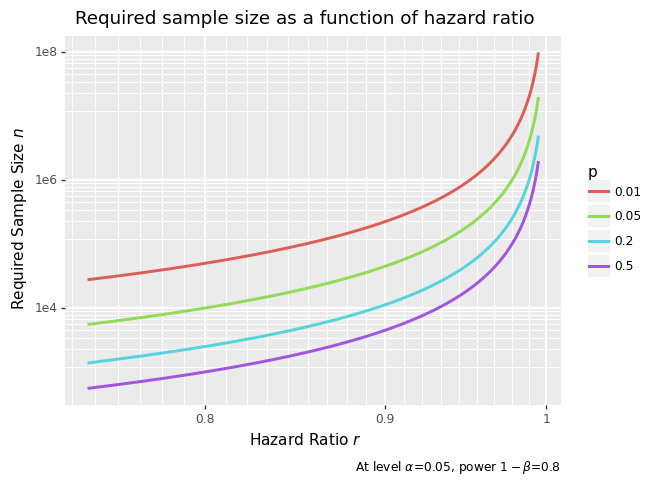

<ggplot: (8789123832418)>

In [13]:
mortality_probabilities = [0.01, 0.05, 0.2, 0.5]
hazard_ratios = np.exp(-np.linspace(0.005, 0.3, num=1000))
point_estimates = (
    pd.DataFrame(index=pd.MultiIndex.from_product([mortality_probabilities, hazard_ratios], names=["p", "r"]))
    .reset_index()
)
point_estimates["n"] = compute_required_sample_size(r=point_estimates["r"], level=level, power=power, p=point_estimates["p"])
point_estimates["p"] = point_estimates["p"].astype("str")
(
    ggplot(data=point_estimates, mapping=aes(x="r", y="n", colour="p")) +
        geom_line(size=1.2) + 
        scale_x_log10() +
        scale_y_log10() +
        labs(x = "Hazard Ratio $r$", y = "Required Sample Size $n$", title="Required sample size as a function of hazard ratio", caption=f"At level $\\alpha$={level}, power $1 - \\beta$={power}") +
        theme(panel_grid_minor = element_line(size = 0.7), panel_grid_major = element_line(size = 1.3))
)

So for example: in a study in which we expect 5% of the population to die, for which the treatment group is has a hazard 3% less than the control group, the required sample size is around 500,000.

In [14]:
compute_required_sample_size(0.97, level=level, power=power, p=0.05)

533115.0386971154

### Bayesian Estimate Example

Now I'll look at what sample size you will expect to need under an example prior over $r$.

I'll use a lognormal prior over $-\log r$ (minus log r), aiming for a median at $r = 0.97$, and a 95% quantile at $r = 0.9$.
This median corresponds to an effect that is roughly 1/10 the effect of having an outpatient appointment randomly canceled once per year, and is within the range of "plausible" effect sizes observed in the Karnataka experiment.

The 5%, 50% and 95% quantiles for r are [0.90474519 0.97052152 0.991126  ] respectively


/home/chris/.mambaforge/envs/play/lib/python3.10/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_density : Removed 66 rows containing non-finite values.


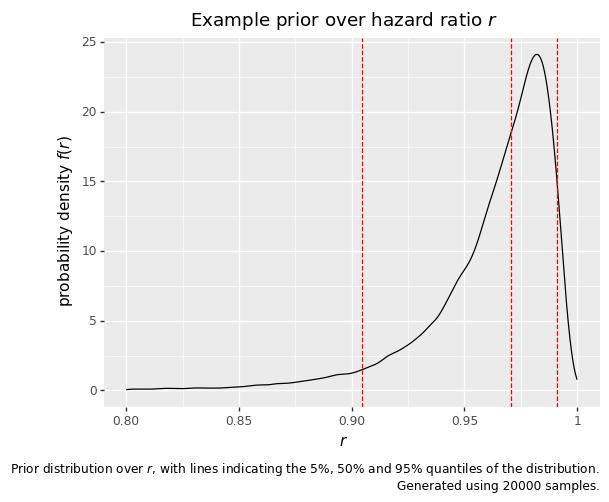

<ggplot: (8789121551189)>

In [15]:
n_samples = 20000
normal_params = {"loc": np.log(0.03), "scale": np.log(2.1)}

r_prior = np.exp(-np.exp(norm.rvs(size = n_samples, **normal_params)))

r_quantiles = np.quantile(r_prior, [0.05, 0.5, 0.95])

print(f"The 5%, 50% and 95% quantiles for r are {r_quantiles} respectively")
(
    ggplot(mapping = aes(x = r_prior))+
        geom_density() +
        xlim(0.8, 1) +
        geom_vline(xintercept = r_quantiles, colour = "red", linetype = "dashed") +
        labs(x = "$r$", y="probability density $f(r)$", title="Example prior over hazard ratio $r$", caption=f"Prior distribution over $r$, with lines indicating the 5%, 50% and 95% quantiles of the distribution.\nGenerated using {n_samples} samples.")
)

Under this prior, the distribution of the required sample size (for 80% power at a 5% significance level) is shown below:

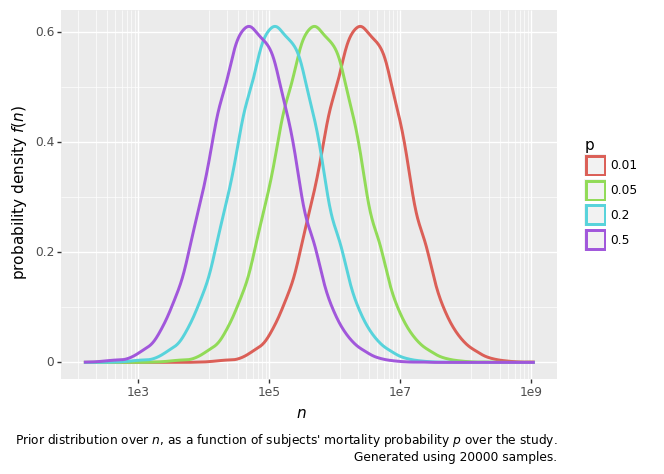

<ggplot: (8789121472642)>

In [18]:
bayesian_df = (
    pd.DataFrame(index=pd.MultiIndex.from_product([mortality_probabilities, r_prior], names=["p", "r"]))
    .reset_index()
)
bayesian_df["n"] = compute_required_sample_size(r=bayesian_df["r"], level=level, power=power, p=bayesian_df["p"])
bayesian_df["p"] = bayesian_df["p"].astype("str")

(
    ggplot(data=bayesian_df, mapping = aes(x = "n", colour="p")) +
        geom_density(size=1.2) +
        scale_x_log10() +
        labs(x="$n$", y="probability density $f(n)$", caption=f"Prior distribution over $n$, as a function of subjects' mortality probability $p$ over the study.\nGenerated using {n_samples} samples.")
)

For example: in a study in which we expect 5% of the sample to die, the 5th, 50th (median) and 95th percentiles of required sample size are \~50,000, \~550,000 and \~6,500,000 respectively.

In [19]:
bayesian_df.set_index("p").xs("0.05")["n"].quantile([0.05, 0.5, 0.95])

0.05    4.935978e+04
0.50    5.524406e+05
0.95    6.225175e+06
Name: n, dtype: float64

Alternative, in a study where we expect 1/2 of the sample to die, these quantiles are 5000, 55,000 and 600,000.

In [20]:
bayesian_df.set_index("p").xs("0.5")["n"].quantile([0.05, 0.5, 0.95])

0.05      4935.978311
0.50     55244.060878
0.95    622517.452224
Name: n, dtype: float64

# Potential Improvements

* Look at more evidence.

* Perform a similar estimate based on a different "quality of life" measure - e.g. self-reported health or physiological variables.